# Proyek Klasifikasi Gambar: CIFAR-10
- **Nama:** Alridho Tristan Satriawan
- **Email:** alridho.tristan@gmail.com
- **ID Dicoding:** Alridho Tristan Satriawan

## Import Semua Packages/Library yang Digunakan

In [1]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

In [2]:
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [3]:
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [25]:
import os
import shutil
from google.colab import files

## Data Preparation

### Data Loading

In [6]:
from tensorflow.keras.datasets import cifar10

print("Loading CIFAR-10 dataset...")
(x_train_original, y_train_original), (x_test_original, y_test_original) = cifar10.load_data()

print(f"Original train set: {x_train_original.shape}")
print(f"Original test set: {x_test_original.shape}")


Loading CIFAR-10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step
Original train set: (50000, 32, 32, 3)
Original test set: (10000, 32, 32, 3)


In [7]:
print("\nMenggabungkan train dan test set...")
x_all = np.concatenate([x_train_original, x_test_original], axis=0)
y_all = np.concatenate([y_train_original, y_test_original], axis=0)

print(f"Total combined data: {x_all.shape}")
print(f"Total combined labels: {y_all.shape}")


Menggabungkan train dan test set...
Total combined data: (60000, 32, 32, 3)
Total combined labels: (60000, 1)


Data Checking

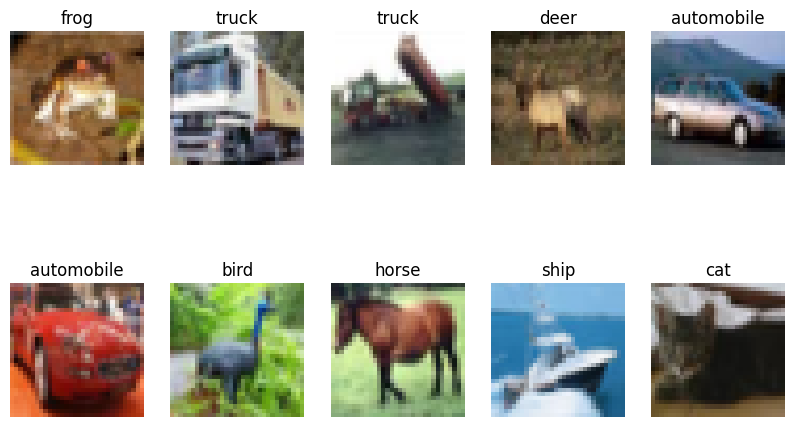

In [8]:
import matplotlib.pyplot as plt
import numpy as np

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

plt.figure(figsize=(10,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_all[i])
    plt.title(class_names[y_all[i][0]])
    plt.axis("off")
plt.show()

### Data Preprocessing

Normalisasi

In [9]:
print("\nNormalizing data...")
x_all = x_all.astype("float32") / 255.0

print(f"Data range after normalization: [{x_all.min():.2f}, {x_all.max():.2f}]")


Normalizing data...
Data range after normalization: [0.00, 1.00]


One-Hot Encodin

In [10]:
y_all = to_categorical(y_all, 10)

#### Split Dataset

In [11]:
from sklearn.model_selection import train_test_split

y_all_flat = np.argmax(y_all, axis=1)

# Train (70%) vs Temp (30%)
x_train, x_temp, y_train_flat, y_temp_flat = train_test_split(
    x_all, y_all_flat,
    test_size=0.30,
    stratify=y_all_flat,
    random_state=42
)

# Validation (15%) vs Test (15%)
x_val, x_test, y_val_flat, y_test_flat = train_test_split(
    x_temp, y_temp_flat,
    test_size=0.50,
    stratify=y_temp_flat,
    random_state=42
)

y_train = to_categorical(y_train_flat, 10)
y_val = to_categorical(y_val_flat, 10)
y_test = to_categorical(y_test_flat, 10)

print("Train:", x_train.shape)
print("Validation:", x_val.shape)
print("Test:", x_test.shape)

print("\nDistribusi kelas seimbang:")
print("Train:", np.bincount(y_train_flat))
print("Val:", np.bincount(y_val_flat))
print("Test:", np.bincount(y_test_flat))

Train: (42000, 32, 32, 3)
Validation: (9000, 32, 32, 3)
Test: (9000, 32, 32, 3)

Distribusi kelas seimbang:
Train: [4200 4200 4200 4200 4200 4200 4200 4200 4200 4200]
Val: [900 900 900 900 900 900 900 900 900 900]
Test: [900 900 900 900 900 900 900 900 900 900]


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(x_train)

## Modelling

In [13]:
model = models.Sequential([
    layers.Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(32,32,3)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=15,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=5,
        factor=0.5,
        min_lr=1e-6
    )
]

In [16]:
print("Starting training...")
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Starting training...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


657/657 ━━━━━━━━━━━━━━━━━━━━ 59s 67ms/step - accuracy: 0.3495 - loss: 2.0441 - val_accuracy: 0.5631 - val_loss: 1.2110 - learning_rate: 0.0010
Epoch 2/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 32s 49ms/step - accuracy: 0.5780 - loss: 1.2027 - val_accuracy: 0.5929 - val_loss: 1.2208 - learning_rate: 0.0010
Epoch 3/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 31s 48ms/step - accuracy: 0.6637 - loss: 0.9598 - val_accuracy: 0.7211 - val_loss: 0.8127 - learning_rate: 0.0010
Epoch 4/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 32s 48ms/step - accuracy: 0.7060 - loss: 0.8519 - val_accuracy: 0.7082 - val_loss: 0.8866 - learning_rate: 0.0010
Epoch 5/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.7334 - loss: 0.7775 - val_accuracy: 0.7446 - val_loss: 0.7856 - learning_rate: 0.0010
Epoch 6/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.7561 - loss: 0.7046 - val_accuracy: 0.7697 - val_loss: 0.6840 - learning_rate: 0.0010
Epoch 7/100
657/657 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.7681 - loss: 

## Evaluasi dan Visualisasi

In [17]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9067 - loss: 0.2996
Test accuracy: 0.9052222371101379


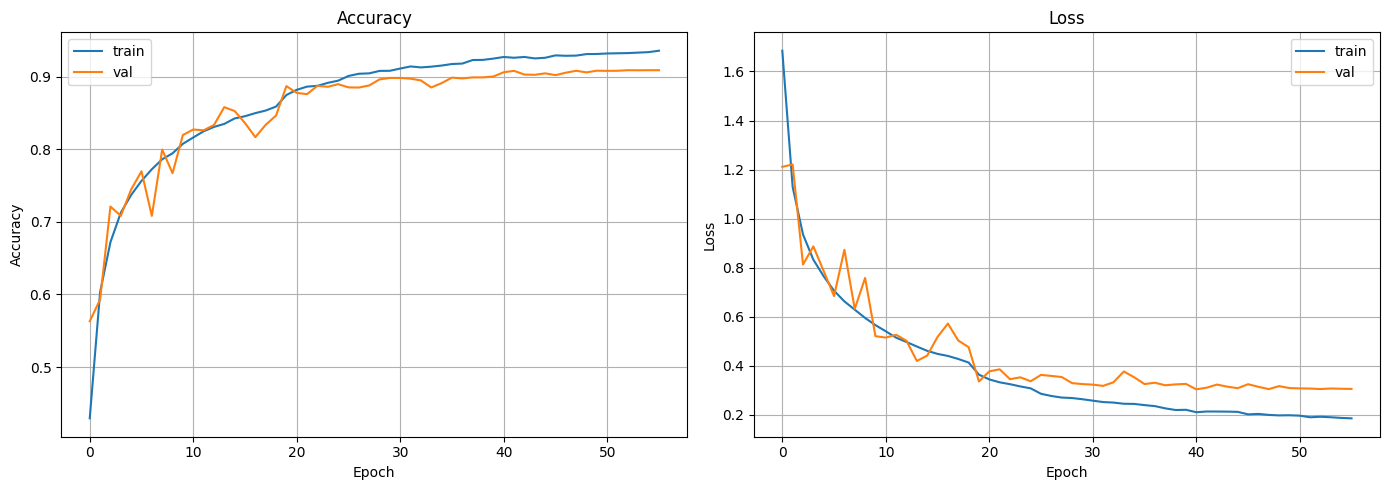

In [18]:
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Konversi Model

Saved Model

In [19]:
model.export("saved_model")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  135972245496912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135971899943312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135971899945232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135971899945424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135971899944272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135971899944656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135971899940624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135971899944464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135971899942544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135971899946576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135971899946384: Ten

TF Lite

In [20]:
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)


TF.js

In [21]:
!pip install tensorflowjs
!tensorflowjs_converter \
  --input_format=tf_saved_model \
  saved_model tfjs_model


INFO: pip is looking at multiple versions of wheel to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: wheel
    Found existing installation: wheel 0.46.3
    Uninstalling wheel-0.46.3:
      Successfully uninstalled wheel-0.46.3
  Attempting uninstall: packaging
    Found existing installation: packaging 26.0
    Uninstalling packaging-26.0:
      Successfully uninstalled packaging-26.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.40.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.12.0 requires pac

2026-02-06 10:39:16.395415: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770374356.417604    9442 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770374356.423776    9442 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770374356.440560    9442 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770374356.440600    9442 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770374356.440608    9442 computation_placer.cc:177] computation placer alr

## Inference (Optional)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


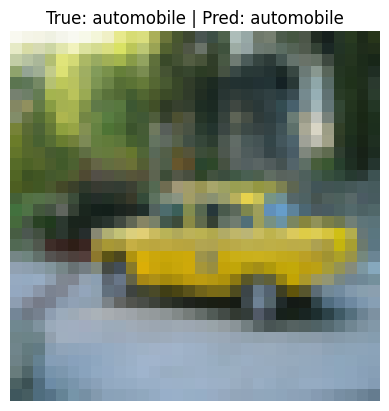

In [22]:
idx = 10

img = x_test[idx]
true_label = np.argmax(y_test[idx])

pred = model.predict(img.reshape(1,32,32,3))
pred_label = np.argmax(pred)

plt.imshow(img)
plt.title(f"True: {class_names[true_label]} | Pred: {class_names[pred_label]}")
plt.axis("off")
plt.show()


Saving 317500461.jpg to 317500461 (2).jpg


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


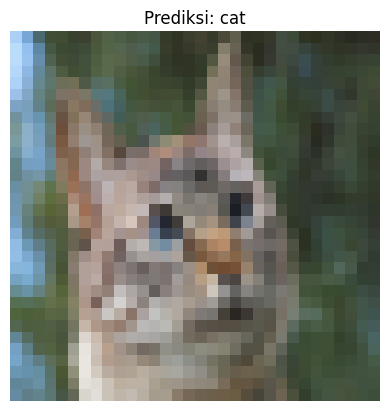

In [28]:
from google.colab import files
import tensorflow as tf # Import tensorflow

uploaded = files.upload()


img_path = list(uploaded.keys())[0]

# !pip install tflite-runtime # This line caused the error and is not needed if using tf.lite
# from tflite_runtime.interpreter import Interpreter # This line caused the error and is not needed if using tf.lite
interpreter = tf.lite.Interpreter(model_path="model.tflite") # Use tf.lite.Interpreter
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


img = Image.open(img_path).resize((32, 32))
img_array = np.array(img, dtype=np.float32) / 255.0
img_array = np.expand_dims(img_array, axis=0)


interpreter.set_tensor(input_details[0]['index'], img_array);
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
pred_label = np.argmax(output_data)


class_names = ["airplane","car","bird","cat","deer","dog","frog","horse","ship","truck"]
plt.imshow(img)
plt.title(f"Prediksi: {class_names[pred_label]}")
plt.axis("off")
plt.show()